<a href="https://colab.research.google.com/github/samitha278/transformer-optim/blob/main/lora_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset prp

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


## Simple Neural Network

In [4]:
class SimpleNN(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super().__init__()
        self.linear1 = nn.Linear(28*28, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, 10)
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

simple_nn = SimpleNN().to(device)

### vanila SGD from scratch

In [5]:
class SGD:
    def __init__(self, parameters, lr: float = 0.01):

        self.params = parameters  # Store references to parameters
        self.lr = lr  # Learning rate

    def zero_grad(self):
        """Clear gradients of all parameters"""
        for param in self.params:
            # Check if parameter has gradients
            if param.grad is not None:
                # Set gradient tensor to zeros (in-place)
                param.grad.zero_()

    def step(self):
        """Update parameters using gradients"""
        for param in self.params:
            # Skip parameters without gradients
            if param.grad is None:
                continue

            # SGD update rule: param = param - lr * gradient
            # .data accesses the tensor data without affecting gradient computation
            param.data = param.data - self.lr * param.grad

## Trainer

In [14]:
cross_el = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(simple_nn.parameters())
epochs = 1

losses = []
val_losses = []
j = 0

for i in range(epochs):

    simple_nn.train()          # activate train mode

    for x , y in iter(train_loader):
        x,y = x.to(device),y.to(device)  # move to device

        logits = simple_nn(x)
        loss = cross_el(logits,y)

        optimizer.zero_grad()  # param.grad = 0
        loss.backward()        # update param.grad
        optimizer.step()       # update param.data



        # validation
        if j%100==0:
            total_val_loss,k  = 0,0
            simple_nn.eval()

            with torch.no_grad():
                for a,b in iter(test_loader):
                    a,b = a.to(device),b.to(device)

                    out = simple_nn(a)
                    error = F.cross_entropy(out,b)

                    k+=1
                    total_val_loss+=error.item()

                val_losses.append(total_val_loss/k)
            simple_nn.train()


        # extra
        loss = loss.item()
        losses.append(loss)
        j+=1
        if j% 1000==0:
            print(f'{j} loss: {loss}')



1000 loss: 0.0022019061725586653
2000 loss: 0.9121325612068176
3000 loss: 0.062082163989543915
4000 loss: 0.011284341104328632
5000 loss: 7.072254084050655e-05
6000 loss: 0.0062163230031728745


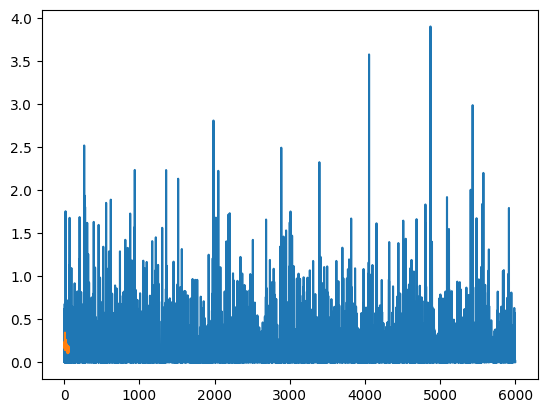

In [15]:
plt.plot(losses)
plt.plot(val_losses)

In [8]:
class LoRALayer(nn.Module):

    def __init__(self,r=8,alpha=16):
        super().__init__()




